In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
from scipy.integrate import RK45

import sympy as sym

from table_maker import *
from functools import partial
from itertools import *
from math import ceil

import pickle

def cos_bell(x, center=0, width=2*np.pi, height=1):
    return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

From [Kilpatrick and Bressloff 2010](https://doi.org/10.1016/j.physd.2009.06.003)
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,x^\prime) q(x^\prime,t) f( u(x^\prime,t) - a(x^\prime,t)) \ dx^\prime \\
    q_t &= \frac{1 - q}{\alpha} - \beta q f(u - a) \\
    \epsilon a_t &= -a + \gamma f(u - a)
\end{align*}$$

Modified version - remove synaptic depression $q$
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,x^\prime) f( u(x^\prime,t) - a(x^\prime,t)) \ dx^\prime \\
    \alpha a_t &= -a + \gamma f(u - a)
\end{align*}$$
(note that parameters have been relabeled)

# Traveling pulse solution

Beginning at (Kilpatrick & Bressloff 2010)[https://www.sciencedirect.com/science/article/abs/pii/S0167278909001833] equations 3.30 and 3.31. We will use the same notation they use (i.e. we will use the $\alpha$ and $\epsilon$ they use and substitute back to our notation later.

In [3]:
import collections.abc
def collect_eqn(expr, terms):
    if not isinstance(terms, collections.abc.Container):
        term = terms # isn't a list or tuple
        left, right = 0,0
        for my_expr in expr.args:
            has_term = False
            for my_term in sym.postorder_traversal(my_expr):
                if term == my_term:
                    has_term = True
                    break
            if has_term:
                left += my_expr
            else:
                right -= my_expr
        return sym.Eq(left, right, evaluate=False)
    else: # isn't a list or tuple
        left_total, right_total = 0, expr
        for term in terms:
            left, right = collect_eqn(right_total, term).args
            left_total += left
            right_total = -right
        return sym.Eq(left_total, right_total, evaluate=False)
    
def my_print(expr):
    global eviron_print_tex
    if eviron_print_tex:
        print('$$' + sym.latex(expr) + '$$')
    else:
        display(expr)
        
def batch_print(expr_list, punctuation='.'):
    global eviron_print_tex
    if eviron_print_tex:
        print_str = '$$\\begin{align*}\n'
        for expr in expr_list:
            print_str += '\t' + sym.latex(expr).replace('=','&=') + '\\\\\n'
        # remove last new-line and add ending puncuation
        print_str = print_str[:-3] + punctuation + '\n'
        print_str += '\\end{align*}$$'
        print(print_str)
    else:
        for expr in expr_list:
            display(expr)
            
def py_code(expr, replace_numpy=True, replace_unicode=True, numpy_package='np.'):
    code = sym.ccode(expr)
    
    if replace_unicode:
        unicode_replacements = [
            ('\\alpha', 'α'),
            ('\\beta', 'β'),
            ('\\gamma', 'γ'),
            ('\\Gamma', 'Γ'),
            ('\\delta', 'δ'),
            ('\\Delta', 'Δ'),
            ('\\epsilon', 'ϵ'),
            ('\\zeta', 'ζ'),
            ('\\eta', 'η'),
            ('\\theta', 'θ'),
            
        ]
        for unicode, symbol in unicode_replacements:
            code = code.replace(unicode, symbol)
    
    if replace_numpy:
        numpy_replacements = [
            ('exp', numpy_package + 'exp'),
            ('log', numpy_package + 'log'),
            ('pow', '( lambda base, exponent: base**exponent )')
        ]
        for c_func, np_func in numpy_replacements:
            code = code.replace(c_func, np_func)
        
    return code

In [4]:
# eviron_print_tex = True
eviron_print_tex = False

c, Δ, α, β, ϵ, γ, θ = sym.symbols('c \\Delta \\alpha \\beta \\epsilon \\gamma \\theta', real=True)

one_plus = 1+α*β
cα = c*α

K0 = (c*α + 1)/( 2*(c+1)*(cα + one_plus) )
K1 = 1/ (2*(c+1)*one_plus)
K2 = β*c*α**2 / ( 2 * (c+1) * one_plus * (c*α + one_plus) )

L0 = (2*c+1) / 2 / (c+1) / one_plus - γ
L1 = (c*α - 1) / ( 2 * (c-1) * (cα - one_plus) )
L2 = β*c**2*α**4 / one_plus / (cα**2 - one_plus**2) / (α - one_plus) - β*c*α**2 / 2 / (c+1) / one_plus / (cα + one_plus)
L3 = 1/one_plus * ( 1 + β*c**2*α**4 / (cα**2 - one_plus**2) / (α - one_plus) ) + (cα**2*(1+β) - one_plus) / (c**2 - 1) / (cα**2 - one_plus**2)

# symbolic values for printing purposes
symK0, symK1, symK2, symL0, symL1, symL2, symL3 = sym.symbols('K_0 K_1 K_2 L_0 L_1 L_2 L_3')

expr1 = -θ + symK0 - symK1*sym.exp(-Δ) - symK2*sym.exp(-one_plus*Δ/cα)*sym.exp(-Δ)
expr2 = -θ + symL0 + symL1*sym.exp(-Δ) + symL2*sym.exp(-one_plus*Δ/cα) - symL3*sym.exp(-Δ/c) + γ*sym.exp(-Δ/(c*ϵ))

sym_pairs = [[0, expr1], [0, expr2], [symK0, K0], [symK1, K1], [symK2, K2], [symL0, L0], [symL1, L1], [symL2, L2], [symL3, L3]]

print('We begin with')
batch_print([ sym.Eq(symvar, var) for symvar, var in sym_pairs ])
    
print('Then set $\\beta=0$ to obtain')

sub_var , sub_to = β, 0
K0 = sym.simplify(K0.subs(sub_var, sub_to))
K1 = K1.subs(sub_var, sub_to)
K2 = K2.subs(sub_var, sub_to)
L0 = L0.subs(sub_var, sub_to)
L1 = L1.subs(sub_var, sub_to)
L2 = L2.subs(sub_var, sub_to)
L3 = L3.subs(sub_var, sub_to)
expr1 = expr1.subs(sub_var, sub_to)
expr2 = expr2.subs(sub_var, sub_to)
sym_pairs = [[0, expr1], [0, expr2], [symK0, K0], [symK1, K1], [symK2, K2], [symL0, L0], [symL1, L1], [symL2, L2], [symL3, L3]]

batch_print([ sym.Eq(symvar, var) for symvar, var in sym_pairs ])
    
print('Substituting, we find')
for var, val in sym_pairs[2:]:
    expr1 = expr1.subs(var, val)
    expr2 = expr2.subs(var, val)
expr2 = sym.simplify(sym.expand(expr2))
expr2 = expr2.collect(sym.exp(-Δ/(ϵ*c))).collect(sym.exp(-Δ)).collect(γ).collect(c)
sym_pairs = [[0, expr1], [0, expr2], [symK0, K0], [symK1, K1], [symK2, K2], [symL0, L0], [symL1, L1], [symL2, L2], [symL3, L3]]
batch_print([ sym.Eq(symvar, var) for symvar, var in sym_pairs[:2] ])

print('Solving the first equation for $e^{-\\Delta}$ and substituting, we obtain')

E_sub = sym.solve(expr1, sym.exp(-Δ))[0]
assert (E_sub - sym.exp(-Δ)) - (expr1*2*(c+1)).simplify() == 0 #expr1=0 so expr1*2*(c+1)=0
expr2 = expr2.subs(sym.exp(-Δ), E_sub).subs(sym.exp(-Δ/c), E_sub**(1/c)).subs(sym.exp(-Δ/(ϵ*c)), E_sub**(1/(ϵ*c)))
batch_print([ sym.Eq(sym.exp(-Δ), E_sub), sym.Eq(0, expr2)])

print('Rearranging, we arrive at a one-dimensional root finding problem for $c$, and some simple substitution for $\\Delta$')
temp = (1 - 2*θ*(c+1))
expr3 = γ*(temp**(1/(ϵ*c)) - 1) + (- 2*θ*c + c**2*(1-2*θ - temp**(1/(c))) ) / (c**2 - 1)
assert (expr2 - expr3).simplify() == 0
expr2 = expr3
# Δ_sub = sym.solve(expr1, Δ)[0]
Δ_sub = sym.log(1/(1 - 2*θ*(c+1))) # sympy is having trouble verifying log identities
batch_print([ sym.Eq(Δ, Δ_sub), sym.Eq(0, expr2) ])

print('Converting to our parameter naming conventions $\\epsilon \\to 1/\\alpha$ we have')
expr2 = expr2.subs(ϵ, 1/α)
batch_print([ sym.Eq(Δ, Δ_sub), sym.Eq(0, expr2) ])

We begin with


Eq(0, K_0 - K_1*exp(-\Delta) - K_2*exp(-\Delta)*exp(\Delta*(-\alpha*\beta - 1)/(\alpha*c)) - \theta)

Eq(0, L_0 + L_1*exp(-\Delta) + L_2*exp(\Delta*(-\alpha*\beta - 1)/(\alpha*c)) - L_3*exp(-\Delta/c) + \gamma*exp(-\Delta/(\epsilon*c)) - \theta)

Eq(K_0, (\alpha*c + 1)/((2*c + 2)*(\alpha*\beta + \alpha*c + 1)))

Eq(K_1, 1/((2*c + 2)*(\alpha*\beta + 1)))

Eq(K_2, \alpha**2*\beta*c/((2*c + 2)*(\alpha*\beta + 1)*(\alpha*\beta + \alpha*c + 1)))

Eq(L_0, -\gamma + (c + 1/2)/((c + 1)*(\alpha*\beta + 1)))

Eq(L_1, (\alpha*c - 1)/((2*c - 2)*(-\alpha*\beta + \alpha*c - 1)))

Eq(L_2, \alpha**4*\beta*c**2/((\alpha*\beta + 1)*(\alpha**2*c**2 - (\alpha*\beta + 1)**2)*(-\alpha*\beta + \alpha - 1)) - \alpha**2*\beta*c/(2*(c + 1)*(\alpha*\beta + 1)*(\alpha*\beta + \alpha*c + 1)))

Eq(L_3, (\alpha**4*\beta*c**2/((\alpha**2*c**2 - (\alpha*\beta + 1)**2)*(-\alpha*\beta + \alpha - 1)) + 1)/(\alpha*\beta + 1) + (\alpha**2*c**2*(\beta + 1) - \alpha*\beta - 1)/((c**2 - 1)*(\alpha**2*c**2 - (\alpha*\beta + 1)**2)))

Then set $\beta=0$ to obtain


Eq(0, K_0 - K_1*exp(-\Delta) - K_2*exp(-\Delta)*exp(-\Delta/(\alpha*c)) - \theta)

Eq(0, L_0 + L_1*exp(-\Delta) + L_2*exp(-\Delta/(\alpha*c)) - L_3*exp(-\Delta/c) + \gamma*exp(-\Delta/(\epsilon*c)) - \theta)

Eq(K_0, 1/(2*(c + 1)))

Eq(K_1, 1/(2*c + 2))

Eq(K_2, 0)

Eq(L_0, -\gamma + (c + 1/2)/(c + 1))

Eq(L_1, 1/(2*c - 2))

Eq(L_2, 0)

Eq(L_3, 1 + 1/(c**2 - 1))

Substituting, we find


Eq(0, -\theta - exp(-\Delta)/(2*c + 2) + 1/(2*(c + 1)))

Eq(0, \gamma*(-1 + exp(-\Delta/(\epsilon*c))) - \theta + c/(c + 1) - exp(-\Delta/c) - 1/(c**2*exp(\Delta/c) - exp(\Delta/c)) + exp(-\Delta)/(2*c - 2) + 1/(2*(c + 1)))

Solving the first equation for $e^{-\Delta}$ and substituting, we obtain


Eq(exp(-\Delta), -2*\theta*c - 2*\theta + 1)

Eq(0, \gamma*((-2*\theta*c - 2*\theta + 1)**(1/(\epsilon*c)) - 1) - \theta + c/(c + 1) - (-2*\theta*c - 2*\theta + 1)**(1/c) - 1/(c**2*(-2*\theta*c - 2*\theta + 1)**(-1/c) - (-2*\theta*c - 2*\theta + 1)**(-1/c)) + (-2*\theta*c - 2*\theta + 1)/(2*c - 2) + 1/(2*(c + 1)))

Rearranging, we arrive at a one-dimensional root finding problem for $c$, and some simple substitution for $\Delta$


Eq(\Delta, log(1/(-2*\theta*(c + 1) + 1)))

Eq(0, \gamma*((-2*\theta*(c + 1) + 1)**(1/(\epsilon*c)) - 1) + (-2*\theta*c + c**2*(-2*\theta - (-2*\theta*(c + 1) + 1)**(1/c) + 1))/(c**2 - 1))

Converting to our parameter naming conventions $\epsilon \to 1/\alpha$ we have


Eq(\Delta, log(1/(-2*\theta*(c + 1) + 1)))

Eq(0, \gamma*((-2*\theta*(c + 1) + 1)**(\alpha/c) - 1) + (-2*\theta*c + c**2*(-2*\theta - (-2*\theta*(c + 1) + 1)**(1/c) + 1))/(c**2 - 1))

In [5]:
code = 'def delta_from_c(c, θ=0.1):\n\treturn ' + py_code(Δ_sub)
print(code.replace('\t',' '*4))

code = 'def c_implicit(c, γ, α, θ=0.1):\n\treturn ' + py_code(expr2)
print(code.replace('\t',' '*4))

code = 'def c_implicit_derivative(c, γ, α, θ=0.1):\n\treturn ' + py_code(expr2.diff(c))
print(code.replace('\t',' '*4))

def delta_from_c(c, θ=0.1):
    return np.log(1.0/(-2*θ*(c + 1) + 1))
def c_implicit(c, γ, α, θ=0.1):
    return γ*(( lambda base, exponent: base**exponent )(-2*θ*(c + 1) + 1, α/c) - 1) + (-2*θ*c + ( lambda base, exponent: base**exponent )(c, 2)*(-2*θ - ( lambda base, exponent: base**exponent )(-2*θ*(c + 1) + 1, 1.0/c) + 1))/(( lambda base, exponent: base**exponent )(c, 2) - 1)
def c_implicit_derivative(c, γ, α, θ=0.1):
    return γ*( lambda base, exponent: base**exponent )(-2*θ*(c + 1) + 1, α/c)*(-2*α*θ/(c*(-2*θ*(c + 1) + 1)) - α*np.log(-2*θ*(c + 1) + 1)/( lambda base, exponent: base**exponent )(c, 2)) - 2*c*(-2*θ*c + ( lambda base, exponent: base**exponent )(c, 2)*(-2*θ - ( lambda base, exponent: base**exponent )(-2*θ*(c + 1) + 1, 1.0/c) + 1))/( lambda base, exponent: base**exponent )(( lambda base, exponent: base**exponent )(c, 2) - 1, 2) + (-2*θ - ( lambda base, exponent: base**exponent )(c, 2)*( lambda base, exponent: base**exponent )(-2*θ*(c + 1) + 1, 1.0/c)*(-2*θ/(c*(-2*θ*(c + 1

In [6]:
def delta_from_c(c, θ=0.1):
    return np.log(1.0/(-2*θ*(c + 1) + 1))
def c_implicit(c, γ, α, θ=0.1):
    return γ*(( lambda base, exponent: base**exponent )(-2*θ*(c + 1) + 1, α/c) - 1) + (-2*θ*c + ( lambda base, exponent: base**exponent )(c, 2)*(-2*θ - ( lambda base, exponent: base**exponent )(-2*θ*(c + 1) + 1, 1.0/c) + 1))/(( lambda base, exponent: base**exponent )(c, 2) - 1)
def c_implicit_derivative(c, γ, α, θ=0.1):
    return γ*( lambda base, exponent: base**exponent )(-2*θ*(c + 1) + 1, α/c)*(-2*α*θ/(c*(-2*θ*(c + 1) + 1)) - α*np.log(-2*θ*(c + 1) + 1)/( lambda base, exponent: base**exponent )(c, 2)) - 2*c*(-2*θ*c + ( lambda base, exponent: base**exponent )(c, 2)*(-2*θ - ( lambda base, exponent: base**exponent )(-2*θ*(c + 1) + 1, 1.0/c) + 1))/( lambda base, exponent: base**exponent )(( lambda base, exponent: base**exponent )(c, 2) - 1, 2) + (-2*θ - ( lambda base, exponent: base**exponent )(c, 2)*( lambda base, exponent: base**exponent )(-2*θ*(c + 1) + 1, 1.0/c)*(-2*θ/(c*(-2*θ*(c + 1) + 1)) - np.log(-2*θ*(c + 1) + 1)/( lambda base, exponent: base**exponent )(c, 2)) + 2*c*(-2*θ - ( lambda base, exponent: base**exponent )(-2*θ*(c + 1) + 1, 1.0/c) + 1))/(( lambda base, exponent: base**exponent )(c, 2) - 1)


# Testing
print(delta_from_c(2))
print(c_implicit(3,4,5))

0.9162907318741552
-3.5593078396296236


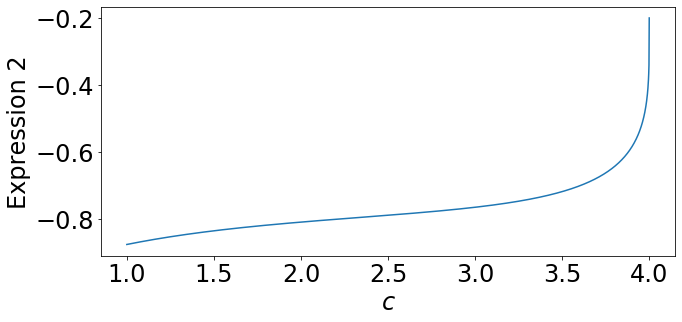

In [7]:
γ = 1
α = 5
θ = .1
c_max = 1/(2*θ) - 1

cs = np.linspace(1+1e-10, c_max, 2001)
plt.figure(figsize=(10,5))
plt.plot(cs, c_implicit(cs, γ, α, θ))
plt.xlabel('$c$')
plt.ylabel('Expression 2')
plt.tight_layout()
# plt.savefig('../reports/report20210527/rootfinding.png')
plt.show()

# Inconsistent

In [8]:
# parameters chosen/measured from simulation
Δ, c, γ, α, θ = pickle.load(open('parameters.pickle', 'rb'))
β = 0
ϵ = 1/α
# α = 1
one_plus = 1+α*β
cα = c*α
K0 = (c*α + 1)/( 2*(c+1)*(cα + one_plus) )
K1 = 1/ (2*(c+1)*one_plus)
K2 = β*c*α**2 / ( 2 * (c+1) * one_plus * (c*α + one_plus) )
L0 = (2*c+1) / 2 / (c+1) / one_plus - γ
L1 = (c*α - 1) / ( 2 * (c-1) * (cα - one_plus) )
L2 = β*c**2*α**4 / one_plus / (cα**2 - one_plus**2) / (α - one_plus) - β*c*α**2 / 2 / (c+1) / one_plus / (cα + one_plus)
L3 = 1/one_plus * ( 1 + β*c**2*α**4 / (cα**2 - one_plus**2) / (α - one_plus) ) + (cα**2*(1+β) - one_plus) / (c**2 - 1) / (cα**2 - one_plus**2)
expr1 = -θ + K0 - K1*sym.exp(-Δ) - K2*sym.exp(-one_plus*Δ/cα)*sym.exp(-Δ)
expr2 = -θ + L0 + L1*sym.exp(-Δ) + L2*sym.exp(-one_plus*Δ/cα) - L3*sym.exp(-Δ/c) + γ*sym.exp(-Δ/(c*ϵ))

print('0 = %g' % expr1)
print('0 = %g' % expr2)
print('Appears inconsistent')

0 = 0.00154503
0 = -0.201793
Appears inconsistent
